In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from fancyimpute import KNN
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


### load the data

In [6]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

### exploration

In [7]:
#basic info on the variable to predict
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

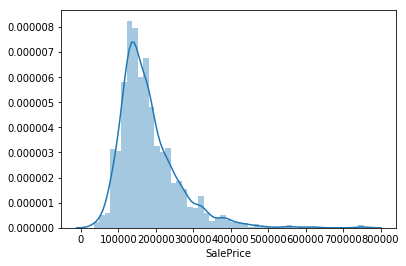

In [8]:
sns.distplot(df_train['SalePrice'])

log transform for a better distribution

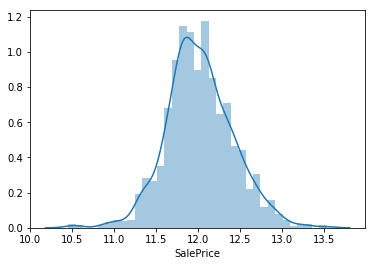

In [9]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'])

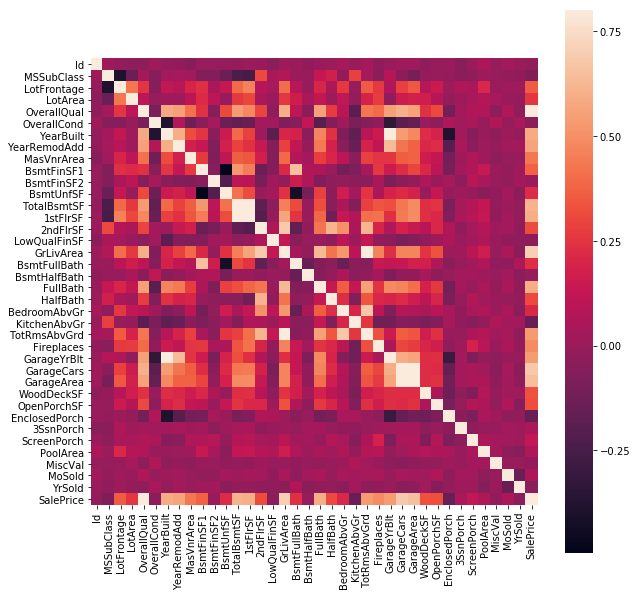

In [10]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, vmax=.8, square=True)

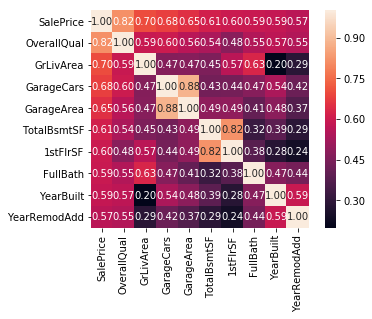

In [11]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
#sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Cleaning

### missing data
merging train and test to clean everything

In [12]:
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)
number = df_all.isnull().sum().sort_values(ascending=False)
percent = (df_all.isnull().sum()/len(df_all.index)).sort_values(ascending=False)
missing = pd.concat([number, percent], axis=1, keys=['Total', 'Percent'])
missing.head(35)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageCond,159,0.054471
GarageQual,159,0.054471


In [13]:
#dealing with missing data by filling na with None or 0 for the relevant features
#filling with None
for i in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
          'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    df_all[i] = df_all[i].fillna('None')

#filling with 0
for i in ('MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
          'GarageArea', 'GarageCars'):
    df_all[i] = df_all[i].fillna(0)

In [14]:
#filling the value
df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [15]:
#remaning missing values
number = df_all.isnull().sum().sort_values(ascending=False)
percent = (df_all.isnull().sum()/len(df_all.index)).sort_values(ascending=False)
missing = pd.concat([number, percent], axis=1, keys=['Total', 'Percent'])
missing.head(10)

,Total,Percent
SalePrice,1459,0.499829
MSZoning,4,0.001370
Utilities,2,0.000685
Functional,2,0.000685
KitchenQual,1,0.000343
Exterior1st,1,0.000343
Exterior2nd,1,0.000343
SaleType,1,0.000343
Electrical,1,0.000343
Fireplaces,0,0.000000


In [16]:
#filling missing values with most frequent value
for i in ('MSZoning', 'Utilities', 'Functional', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Electrical'):
    df_all[i] = df_all[i].fillna(df_all[i].mode()[0])

In [17]:
#verification
df_all.isnull().sum().sort_values(ascending=False)

SalePrice      1459
FullBath          0
ExterCond         0
ExterQual         0
Exterior1st       0
               ... 
MSZoning          0
MasVnrArea        0
MasVnrType        0
MiscFeature       0
1stFlrSF          0
Length: 81, dtype: int64

In [18]:
#onehot encoding and split the data
df_all = pd.get_dummies(df_all)
df_train = df_all[:1460]
df_test = df_all[1460:].drop(['SalePrice'], axis=1)

### outliers

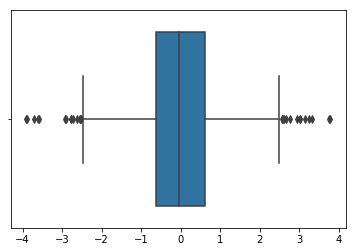

In [19]:
scaled_price = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis])
sns.boxplot(scaled_price)

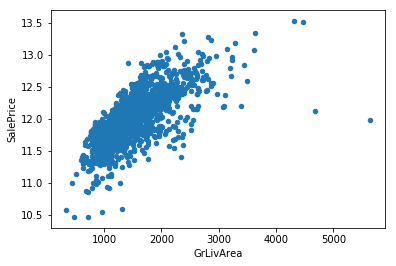

In [20]:
var2 = 'GrLivArea'
bi_var = pd.concat([df_train['SalePrice'], df_train[var2]], axis = 1)
bi_var.plot.scatter(x=var2, y='SalePrice')

In [21]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

## preparing data for predictions

In [22]:
df_train.drop(['Id'], axis=1, inplace=True)
sub_id = df_test.pop('Id')
y_train_all = df_train.pop('SalePrice')
X_train_all = df_train.values
x_train, x_test, y_train, y_test = train_test_split(X_train_all, y_train_all, test_size=0.1, random_state=10)
X_sub = df_test.values

# models testing
most of the parameter tuning has been done using this notebook: https://www.kaggle.com/niteshx2/top-50-beginners-stacking-lgb-xgb

In [23]:
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSLE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))#no need for the log since we log transformed the data

# Shows scores for train and validation sets    
def train_test(estimator, x_train, y_train, x_test, y_test):
    prediction_train = estimator.predict(x_train)
    # Printing train scores
    print("train:")
    get_score(prediction_train, y_train)
    print("test:")
    prediction_test = estimator.predict(x_test)
    # Printing train scores
    get_score(prediction_test, y_test)    

In [24]:
GB = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=10)
GB = GB.fit(x_train, y_train)
train_test(GB, x_train, y_train, x_test, y_test)

train:
R2: 0.982770833891645
RMSLE: 0.05161534354431947
test:
R2: 0.9282789537081851
RMSLE: 0.09239818501712233


In [25]:
BRR = linear_model.BayesianRidge(n_iter=1000)
BRR = BRR.fit(x_train, y_train)
train_test(GB, x_train, y_train, x_test, y_test)

train:
R2: 0.982770833891645
RMSLE: 0.05161534354431947
test:
R2: 0.9282789537081851
RMSLE: 0.09239818501712233


In [26]:
lasso = linear_model.LassoLars(alpha=0.0001, eps=0.9, max_iter=1e6)
lasso = lasso.fit(x_train, y_train)
train_test(lasso, x_train, y_train, x_test, y_test)

train:
R2: 0.9152086410220408
RMSLE: 0.10828468156377993
test:
R2: 0.89755215149421
RMSLE: 0.10329136004756245


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:604: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 96 iterations, alpha=1.702e-04, previous alpha=1.702e-04, with an active set of 93 regressors.
  ConvergenceWarning)


In [27]:
elnet = linear_model.ElasticNet(alpha=0.0004, max_iter=1e5, random_state=10)
elnet = elnet.fit(x_train, y_train)
train_test(elnet, x_train, y_train, x_test, y_test)

train:
R2: 0.9395762421662722
RMSLE: 0.0960578583809867
test:
R2: 0.915532066941876
RMSLE: 0.098455874103937


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4185822145526683, tolerance: 0.02143531349631234
  positive)


In [28]:
rid = linear_model.Ridge(alpha=0.9, max_iter=1e6, random_state=10)
rid = rid.fit(x_train, y_train)
train_test(rid, x_train, y_train, x_test, y_test)

train:
R2: 0.9456547784344805
RMSLE: 0.09154027762960756
test:
R2: 0.9110898143207479
RMSLE: 0.10276620225676632


In [29]:

lgbm = LGBMRegressor(objective='regression', num_leaves=4, learning_rate=0.01, n_estimators=5000, max_bin=200, bagging_fraction=0.75,
                     bagging_freq=5, bagging_seed=7, feature_fraction=0.2, feature_fraction_seed=7, verbose=-1)
lgbm = lgbm.fit(x_train, y_train)
train_test(rid, x_train, y_train, x_test, y_test)

train:
R2: 0.9456547784344805
RMSLE: 0.09154027762960756
test:
R2: 0.9110898143207479
RMSLE: 0.10276620225676632


In [38]:
xgbREG = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
xgbREG = xgbREG.fit(x_train, y_train)
train_test(xgbREG, x_train, y_train, x_test, y_test)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


train:
R2: 0.9847920699224002
RMSLE: 0.04888314314541832
test:
R2: 0.9216376056423434
RMSLE: 0.0974411855089683


In [31]:
stack = StackingCVRegressor(regressors=(GB, BRR, lasso, elnet, rid, lgbm, xgbREG),
                            meta_regressor=xgbREG, random_state=10, use_features_in_secondary=True)
stack = stack.fit(x_train, y_train)
train_test(stack, x_train, y_train, x_test, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:604: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 123 iterations, alpha=1.311e-04, previous alpha=1.311e-04, with an active set of 120 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.401765697540635, tolerance: 0.017418855293637882
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.467005510614847, tolerance: 0.016998894501858836
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. Y

[16:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:604: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 96 iterations, alpha=1.702e-04, previous alpha=1.702e-04, with an active set of 93 regressors.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4185822145526683, tolerance: 0.02143531349631234
  positive)


[16:17:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train:
R2: 0.9863108600004853
RMSLE: 0.046495715388044506
test:
R2: 0.9230738344637356
RMSLE: 0.0993141355824781


In [32]:
#coefficients can be improved, not using the stacked and lasso
def blended_predict(X):
    return ((2 * GB.predict(X)) +
            (2 * BRR.predict(X)) +
            #(1 * lasso.predict(X)) +
            (1 * elnet.predict(X)) +
            (1 * rid.predict(X)) +
            (1 * lgbm.predict(X)) +
            (3 * xgbREG.predict(X))) / 10

In [33]:
print("train")
get_score(blended_predict(x_train), y_train)    
print("test")
get_score(blended_predict(x_test), y_test)    

train
R2: 0.9718397035317902
RMSLE: 0.06565966601512262
test
R2: 0.9291913096932521
RMSLE: 0.09128935138101867


# prediction

In [39]:
#training final models used in the blending on all the training data
GB = GB.fit(X_train_all, y_train_all)
BRR = BRR.fit(X_train_all, y_train_all)
elnet = elnet.fit(X_train_all, y_train_all)
rid = rid.fit(X_train_all, y_train_all)
lgbm = lgbm.fit(X_train_all, y_train_all)
xgbREG = xgbREG.fit(X_train_all, y_train_all)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.692594168011505, tolerance: 0.02327853920138023
  positive)
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [43]:
get_score(blended_predict(X_train_all), y_train_all)

R2: 0.9709855349472235
RMSLE: 0.06588762749753053


# submission

In [44]:
sub_labels = np.expm1(blended_predict(X_sub))

In [45]:
pd.DataFrame({'Id': sub_id, 'SalePrice': sub_labels}).to_csv('2019-12-16.csv', index=False)